In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures
import time

import duckdb 
conn = duckdb.connect('analysis2.db') # create an in-memory database

In [2]:
conn.sql("SHOW ALL TABLES")

┌───────────┬─────────┬──────────────────────┬──────────────────────┬──────────────────────────────────────┬───────────┐
│ database  │ schema  │         name         │     column_names     │             column_types             │ temporary │
│  varchar  │ varchar │       varchar        │      varchar[]       │              varchar[]               │  boolean  │
├───────────┼─────────┼──────────────────────┼──────────────────────┼──────────────────────────────────────┼───────────┤
│ analysis2 │ main    │ A10_2_AD_FIL         │ [index, AD_BC]       │ [VARCHAR, BIGINT]                    │ false     │
│ analysis2 │ main    │ A10_2_MAP_20240320   │ [AD, AD_BC, RPTR_BC] │ [VARCHAR, VARCHAR, VARCHAR]          │ false     │
│ analysis2 │ main    │ A10_2_RPTR           │ [index, RPTR_BC]     │ [VARCHAR, BIGINT]                    │ false     │
│ analysis2 │ main    │ A10_2_RPTR_FIL       │ [index, RPTR_BC]     │ [VARCHAR, BIGINT]                    │ false     │
│ analysis2 │ main    │ A10_2_TB

In [3]:
A10map1 = pd.read_csv('CURRENT_A10_1_tbcRAW_v2.csv') #read in raw df
A10map1.head(20)

,Unnamed: 0,AD,AD_BC,RPTR_BC,Designed
0,0,ACTTCTAACTTTCATCATGATCAAGAAGCTGACTTTGTCTTGTTTC...,CCCCGCCATGG,CAGTTATCTCGTTA,0
1,1,AAAGCTACTGGTCCACCAGCATCTCCAGTTATTAGAGGTTCTGCTT...,TGCATTCCTAC,ACGGATTAGTCGTA,0
2,2,GGTTCTGGTACTCCACAAAGGAAAGGTTCTGTTGCTTCTACTGGTC...,TTTCAGCTGTT,GAAGGAGCAGGTGC,0
3,3,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,TTCGCTTAATG,AGAAGAACTGAGGA,1
4,4,TCTTGGTTGCCTTCTTCTTCTTCTTCTCCACCAGCTGCATCTGCTC...,CGTTGCTGACA,GAAGGAAATATGAT,0
5,5,ATGTCTGCTCCAAATTCTACTGCTTTGACTGCTTTGACTTCTCCAT...,CCAGGTGATCA,AGACTATAGAAGTG,1
6,6,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TATGAATGTTA,TAATCGGATACGTA,1
7,7,AATCAACAAGCTCCAGATGCTCAACCACATCCATCTTCTCCAGCTC...,TAAGCTCGAGA,ACCTCCTCGCTCGC,0
8,8,NaN,NaN,NaN,0
9,9,CCATCTTCTGATATGTTGTTTGATTTGGTGACTTTCCAGCTTCTCC...,GATCACGTGGA,TAAAAAAAAGAGGG,0


In [4]:
A10map2 = A10map1.copy() #copy raw df
A10map2 = A10map2[A10map2['Designed']==1] # only keep designed tiles

print('Unfiltered # Reads:', A10map1.shape[0])
print('Filtered # Reads:', A10map2.shape[0])

Unfiltered # Reads: 138420998
Filtered # Reads: 48675583


In [5]:
A10map2 = A10map2.drop(columns='Unnamed: 0') #get rid of index column

In [6]:
A10map1rptrbcs = A10map1['RPTR_BC'].value_counts().to_frame().reset_index() #get RPTR_BC coverage (including with nondesigned tiles)
A10map1rptrbcs

,index,RPTR_BC
0,TGCAGGAGCCACTC,25089
1,GGCCCCTTAAGCTC,21258
2,GGGGTTAAGTTGAA,19847
3,GCAACTAACCATTT,15256
4,GCTAAAGGTGGCAT,13624
...,...,...
1687697,GAGGATATCGAATT,1
1687698,GGCTTTACTATATG,1
1687699,TCTTACCTAGCTGT,1
1687700,GTTTGGGGCACCTT,1


In [7]:
conn.sql(""" CREATE TABLE A10_2_RPTR AS SELECT * FROM A10map1rptrbcs""") #save RPTR_BC coverage

<Axes: xlabel='RPTR_BC', ylabel='Count'>

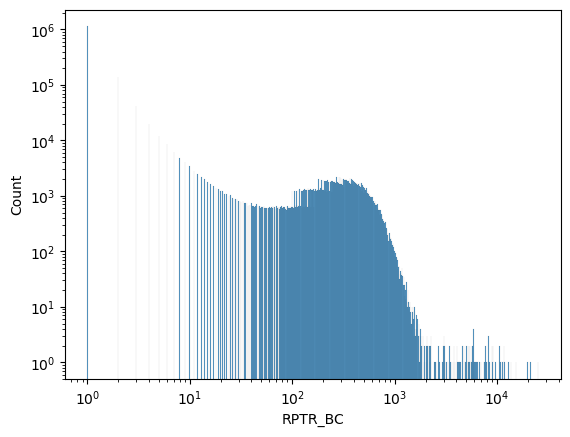

In [8]:
sns.histplot(data=A10map1rptrbcs[A10map1rptrbcs['index']!= 'X'], x='RPTR_BC', log_scale=(True, True)) #visualize RPTR_BC coverage
# plt.xlim(50,1000)
# plt.ylim()

In [9]:
A10map2rptrbcs = A10map2['RPTR_BC'].value_counts().to_frame().reset_index() #get RPTR_BC coverage (only designed tiles)
A10map2rptrbcs

,index,RPTR_BC
0,TGCAGGAGCCACTC,21657
1,GGGGTTAAGTTGAA,17066
2,GCAACTAACCATTT,13562
3,GGCCCCTTAAGCTC,12504
4,GCTAAAGGTGGCAT,12142
...,...,...
604177,TGATTAAGATTATT,1
604178,GTGCCTCGTGAGAG,1
604179,CAAGATATGGTCGT,1
604180,CTCACCTTGAATCA,1


In [10]:
conn.sql(""" CREATE TABLE A10_2_RPTR_FIL AS SELECT * FROM A10map2rptrbcs""")

<Axes: xlabel='RPTR_BC', ylabel='Count'>

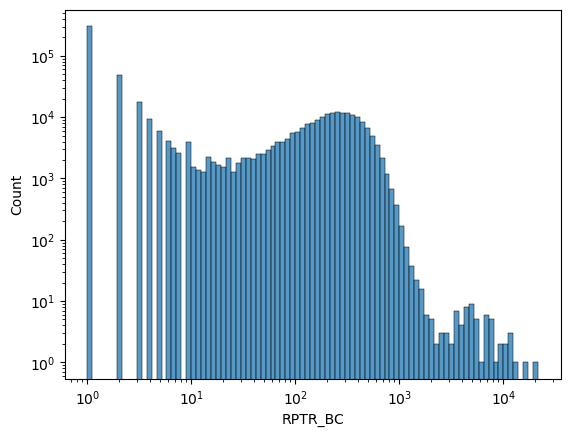

In [11]:
sns.histplot(data=A10map2rptrbcs, x='RPTR_BC', log_scale=(True, True))
# plt.xlim(50,1000)
# plt.ylim()

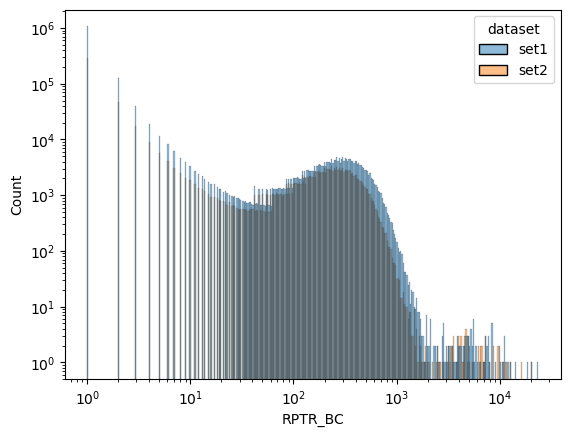

In [11]:
all_rbc = pd.concat([A10map1rptrbcs.assign(dataset='set1'), A10map2rptrbcs.assign(dataset='set2')]) #compare RPTR BC datasets between those with and without designed tiles

sns.histplot(x='RPTR_BC', data=all_rbc, log_scale=(True, True),
                hue='dataset')
plt.savefig('A10_2_rptrbc_filtering.jpg')
plt.show()

In [13]:
A10map2adbcs = A10map2['AD_BC'].value_counts().to_frame().reset_index() #get AD_BC coverage (only designed tiles)
A10map2adbcs

,index,AD_BC
0,GCTAAGGCGTA,21531
1,AAGAGCCGGTA,17000
2,TGTACCTACAT,13526
3,AGTAGTTAATA,12081
4,ATTGATAGGAC,11406
...,...,...
657931,ATTCTCAAAAC,1
657932,TTAAACAATAC,1
657933,GCATGCACCTA,1
657934,TATGTTGATAC,1


In [14]:
conn.sql(""" CREATE TABLE A10_2_AD_FIL AS SELECT * FROM A10map2adbcs""") #save AD_BC coverage

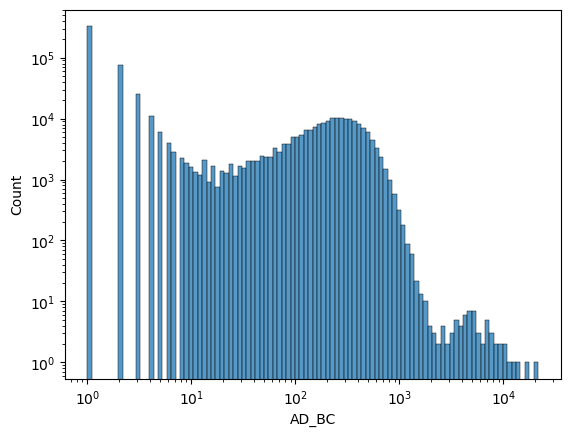

In [15]:
sns.histplot(x='AD_BC', data=A10map2adbcs, log_scale=(True, True)) #plot AD_BC coverage
# plt.savefig('A10_2_adbc_filtering.jpg')
plt.show()

In [16]:
A10map2tiles = A10map2['AD'].value_counts().to_frame().reset_index() #get tile coverage
A10map2tiles

,index,AD
0,CAACAAACTCAACCATTGCCAGAATTGGTTCAACCAGTTCAACCAA...,24881
1,TCTGCTGATTATTCTGGTTTGCAATCTGATTATTCTCCATTGACTG...,20587
2,TTGGCTTCTGATTCTTTGCCACCATTGCCACCAACTCCAAGATCTC...,19060
3,AATAATTTGCCATCTGATTGGTTGTGTTCTGGTAATGGTGGTAATA...,18733
4,GATCAAGCTTTGTCTGGTGATCCATGGTATCCATTGTTTCCACAAG...,15761
...,...,...
20630,ATTAATGAAGTTCCATCTAATAATTCTAATAATAATAATAATAATA...,5
20631,AAAGGTTCTACTACTGGTGCTGGTGTTAGGAAGAGAACTGCTCCAT...,4
20632,ATGAAGAGAGCTAGAAATACTTTGGCTGCTAGGAAATCTAGAGAAA...,3
20633,AATAATAATAATAATAATAATACTTCTAATAATGGATTCTCTGCTA...,2


In [17]:
conn.sql(""" CREATE TABLE A10_2_TILE_FIL AS SELECT * FROM A10map2tiles""")

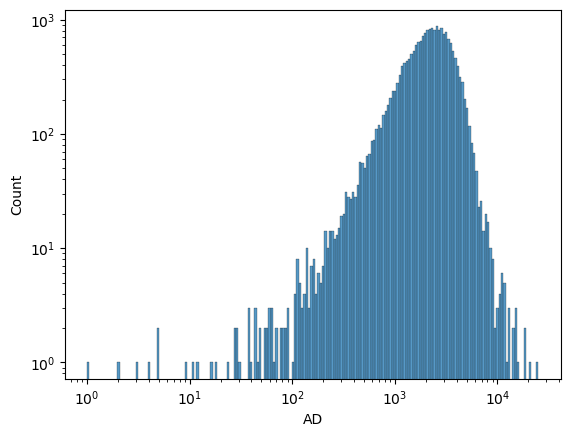

In [18]:
# all_tile = pd.concat([A10map1tiles.assign(dataset='set1'), A10map2tiles.assign(dataset='set2')])

sns.histplot(x='AD', data=A10map2tiles, log_scale=(True, True))
plt.show()

In [7]:
A10map2.head()

,AD,AD_BC,RPTR_BC,Designed
3,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,TTCGCTTAATG,AGAAGAACTGAGGA,1
5,ATGTCTGCTCCAAATTCTACTGCTTTGACTGCTTTGACTTCTCCAT...,CCAGGTGATCA,AGACTATAGAAGTG,1
6,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TATGAATGTTA,TAATCGGATACGTA,1
10,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,GGTCGAAGTTC,AATTGACCCGTCAG,1
13,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,CGGCCCTTTCC,ATGGCGCCCTCGAA,1


In [8]:
A10map2_TBB = A10map2.copy() #add a column with Tile-BC-BC strings
adcol = A10map2_TBB['AD_BC'].copy() #get the AD_BCs as a series
rpcol = A10map2_TBB['RPTR_BC'].copy() #get the RPTR_BCs as a series

A10map2_TBB['Cat'] = A10map2_TBB['AD'].str.cat(adcol, sep="-").str.cat(rpcol, sep="-") #Concatenate Tiles(ADs) with the AD BCs and RPTR BCs
# A10map2_TBB['BC Pairs'] = A10map2_TBB['AD BCs'].str.cat(rpcol, sep='-')

A10map2_TBB.head()

,AD,AD_BC,RPTR_BC,Designed,Cat
3,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,TTCGCTTAATG,AGAAGAACTGAGGA,1,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...
5,ATGTCTGCTCCAAATTCTACTGCTTTGACTGCTTTGACTTCTCCAT...,CCAGGTGATCA,AGACTATAGAAGTG,1,ATGTCTGCTCCAAATTCTACTGCTTTGACTGCTTTGACTTCTCCAT...
6,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TATGAATGTTA,TAATCGGATACGTA,1,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...
10,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,GGTCGAAGTTC,AATTGACCCGTCAG,1,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...
13,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,CGGCCCTTTCC,ATGGCGCCCTCGAA,1,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...


In [12]:
map2_TBBcounts = A10map2_TBB['Cat'].value_counts().to_frame().reset_index() #get Tile-BC-BC (TBB) coverage
map2_TBBcounts

,index,Cat
0,CAACAAACTCAACCATTGCCAGAATTGGTTCAACCAGTTCAACCAA...,21419
1,AATAATTTGCCATCTGATTGGTTGTGTTCTGGTAATGGTGGTAATA...,16874
2,GATCAAGCTTTGTCTGGTGATCCATGGTATCCATTGTTTCCACAAG...,13429
3,CCAGACTTTGATGCTTTGTTTGATTTGACTGCTAATTCATTTGTTG...,11970
4,GCTGTTGTTACTACTTCTGCTGCTTCTCAAGGTGCTGGTGGTAATT...,11286
...,...,...
1210029,TTGGGTGGTGATATTACTGCATTTGTTCAACCATCTTCTTTGTATG...,1
1210030,ACTCAACCAGATCAATCTGGTCCAATTAATCATTCTAATTTGAATC...,1
1210031,AGATTGTTTGAGTTCTGGAATGCTAAAGGTACTCCATTTGGTGATG...,1
1210032,CAAGCTGCTTTGTCTGCTCATAGAAGAAATTCTTCTCATATTGCTT...,1


In [18]:
thresh = map2_TBBcounts[map2_TBBcounts['Cat']>= 50]['index'].to_list()
thresh[:10]

['CAACAAACTCAACCATTGCCAGAATTGGTTCAACCAGTTCAACCAACTGTTCAACCAACTGTTGAACAAACTGTTCATTCTGTTGAAGCTTCTCCAGCTACTCCATCTGAAGATTTGGAA-GCTAAGGCGTA-TGCAGGAGCCACTC',
 'AATAATTTGCCATCTGATTGGTTGTGTTCTGGTAATGGTGGTAATAGAGATGAGAATGTTGAAACTTCTCAAGGTTCTAGGAAAGGTGCTGGTAGACAAACTGGTGGTCAGAATGATGCT-AAGAGCCGGTA-GGGGTTAAGTTGAA',
 'GATCAAGCTTTGTCTGGTGATCCATGGTATCCATTGTTTCCACAAGATAATCAAGTTGAGAAACAAAATTCTCAAGTTGATCAATCTCCATTGTTGCCAGAAGAAGAATTGGAAGTTTCT-TGTACCTACAT-GCAACTAACCATTT',
 'CCAGACTTTGATGCTTTGTTTGATTTGACTGCTAATTCATTTGTTGATGGTTTGGATGCTGCTTCTTTGGCTATGTTTGATACTCAACAATTGGATAAAGTTCAAGCATTTGTTTCTGGT-AGTAGTTAATA-GCTAAAGGTGGCAT',
 'GCTGTTGTTACTACTTCTGCTGCTTCTCAAGGTGCTGGTGGTAATTCTTTGTCTAGATCTGCTGAAATTGCTACTATTGTTGGTGTTATTATTGCTGCTATTACTATTGTTATTATGGTT-ATTGATAGGAC-AAGATAATAATACA',
 'TTGTTTCCACCAGAAGATCAATTTGAAGTTCCTAAGATTGAAGATTCTTCTCCATTGTTGCCAGAAGAAGAATTGGAAGTTTCTGAAGCTTTGAGAACTTCTGCTTCTGGTACTAGAAGA-CGAAGAATAAT-GAGTCATTAATTTC',
 'GGTTGGAGACAATTGGCTGAATGGTCTTTGACTCATTCTTGCTTCTCTTGTCCAGCTGATCAAGCTAGAGCTAGAGCTAATTGGTT

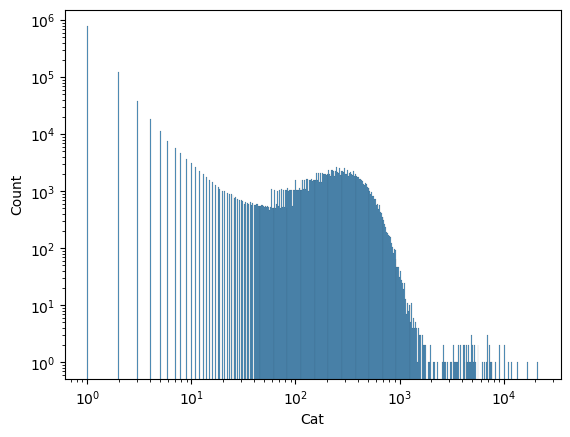

In [9]:
sns.histplot(data=map2_TBBcounts, x='Cat', log_scale=(True, True)) #plot TBB coverage
# plt.savefig('A10_2_TBB_fil_counts.jpg')
plt.show()

In [10]:
map2_TBBcounts.describe()

,Cat
count,1.210034e+06
mean,4.022441e+01
std,1.194232e+02
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,3.000000e+00
max,2.141900e+04


In [ ]:
conn.sql(""" CREATE TABLE A10_2_TBB_FIL AS SELECT * FROM map2_TBBcounts""") #save TBB Coverage

In [ ]:
conn.sql(""" CREATE TABLE A10_2_TBB_THRESH AS SELECT * FROM filtered_map2_TBB""") #save THRESHOLDED TBB Coverage

In [38]:
A10map3 = A10map2_TBB.drop_duplicates().reset_index().drop(columns=['Designed', 'index']) #create df with Tiles and Barcodes as lookup table (no duplicates)

A10map3

,AD,AD_BC,RPTR_BC,Cat
0,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,TTCGCTTAATG,AGAAGAACTGAGGA,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...
1,ATGTCTGCTCCAAATTCTACTGCTTTGACTGCTTTGACTTCTCCAT...,CCAGGTGATCA,AGACTATAGAAGTG,ATGTCTGCTCCAAATTCTACTGCTTTGACTGCTTTGACTTCTCCAT...
2,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TATGAATGTTA,TAATCGGATACGTA,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...
3,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,GGTCGAAGTTC,AATTGACCCGTCAG,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...
4,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,CGGCCCTTTCC,ATGGCGCCCTCGAA,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...
...,...,...,...,...
1210194,TTGCCAGAATTGGTTCAACCAGTTCAACCAACTGTTCAACCAACTG...,GGGGTGCTGAG,ACAGGCGGGATACT,TTGCCAGAATTGGTTCAACCAGTTCAACCAACTGTTCAACCAACTG...
1210195,ACTTCTTCATTTAATCATAGACAAGCTTCTACTTCTTATCAATTTA...,GAGTCGTACCT,GAAAGTATCACTAT,ACTTCTTCATTTAATCATAGACAAGCTTCTACTTCTTATCAATTTA...
1210196,TTGACTTCTCCATCTGACTTTAATGATTCTCCATATGGTGATTCTT...,TTACTGGGAGC,CCCCCTCAGAAAAC,TTGACTTCTCCATCTGACTTTAATGATTCTCCATATGGTGATTCTT...
1210197,AGAAATACTTTGGCTGCTAGGAAATCTAGAGAAAGGAAAGCTTTGA...,CAATGCAGTAG,GTACATTCGCCTTC,AGAAATACTTTGGCTGCTAGGAAATCTAGAGAAAGGAAAGCTTTGA...


In [24]:
conn.sql(""" CREATE TABLE A10_2_MAP_20240320 AS SELECT * FROM A10map3""") #save lookup table to db

In [ ]:
# A10map3.to_parquet('A10_2_MAP_20240330.parquet') #save lookup table to parquet # the saved version doesn't have cat column

In [39]:
A10map4 = A10map3.copy()
A10map4 = A10map4.set_index('Cat')
A10map4 = A10map4[A10map4.index.isin(thresh)] #filter out reads that appear <50 times in the sequencing run
A10map4

,AD,AD_BC,RPTR_BC
Cat,,,
AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTTGTTCTACTTCTAAACCACCAGGTAATTTGTCTAGAACTCATGCTTATTCTTTGCCAACTACTCCACCAGCTACT-TTCGCTTAATG-AGAAGAACTGAGGA,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,TTCGCTTAATG,AGAAGAACTGAGGA
TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACTTTGATTTGTCTATGTTGTCTCCACAACAAATTCCAACTGGTATTATGGCTCCTAAAGAAGCTATGGCTGATGCT-TATGAATGTTA-TAATCGGATACGTA,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TATGAATGTTA,TAATCGGATACGTA
CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCACAAGTTCCATTGTTCTCTCAATCTACTGGTAATGTTCCACAAACTCCAAATATGGCTATGCAAGGTAAATTTCAT-GGTCGAAGTTC-AATTGACCCGTCAG,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,GGTCGAAGTTC,AATTGACCCGTCAG
GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTACTGTTACTCCATTGCAATTGCATTCTTCTATTGTTGAATCTGTCTTCTCTCCATCTATTGAAAATTCTTCTCCA-CGGCCCTTTCC-ATGGCGCCCTCGAA,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,CGGCCCTTTCC,ATGGCGCCCTCGAA
GAAGTTTATACTTCTTTGAGAAGATGTGCTAAAGATTGCTTCTGGGGTTGGAATGGTGGTGCTATTGATCAAATTGGTTATGTCTTGGGTTGTGATACTGTTGAAGGTCAAAGAGCTGTT-GGCTGGAATGT-CCAACTACCCGTGG,GAAGTTTATACTTCTTTGAGAAGATGTGCTAAAGATTGCTTCTGGG...,GGCTGGAATGT,CCAACTACCCGTGG
...,...,...,...
GTTGATAGAACTTTGCAACAAGATAGATTGGTTGGTCCAAGACATTCTCCAGTTCAAGACTTTAGATCTAGATCTTCTACTGCTGGTATCTTGGATACTGAATTTAATGCATTTCAAGCT-GATTGTATGAC-AATGAGAGACCTCA,GTTGATAGAACTTTGCAACAAGATAGATTGGTTGGTCCAAGACATT...,GATTGTATGAC,AATGAGAGACCTCA
CATAATGTTGCTAATATGGCTGATTTAAATTCTAATAATTCATTTGATTCTGGTGCTTCTTTGATGTCTAACTTTAATAATGGTGGATTCTCTTTGGATCATGTTTCTGCATTTACTGCT-ACGTAGTGATG-GGGATGACCCAATC,CATAATGTTGCTAATATGGCTGATTTAAATTCTAATAATTCATTTG...,ACGTAGTGATG,GGGATGACCCAATC
ATGAATGAATCTGTTGGTTCTTCTGGTACTGTTTCTCCTAAAGATTTGTTGAGAGATCCATTGGCTTCTGCTCCACCATCTGCTGCATTTACTAATTTGACTTCTCCATCTATCTTTGAT-GGTGCTGGAAA-GAATGACTTACTAG,ATGAATGAATCTGTTGGTTCTTCTGGTACTGTTTCTCCTAAAGATT...,GGTGCTGGAAA,GAATGACTTACTAG


In [40]:
A10map4 = A10map4.reset_index()
A10map4

,Cat,AD,AD_BC,RPTR_BC
0,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,TTCGCTTAATG,AGAAGAACTGAGGA
1,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TATGAATGTTA,TAATCGGATACGTA
2,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,GGTCGAAGTTC,AATTGACCCGTCAG
3,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,CGGCCCTTTCC,ATGGCGCCCTCGAA
4,GAAGTTTATACTTCTTTGAGAAGATGTGCTAAAGATTGCTTCTGGG...,GAAGTTTATACTTCTTTGAGAAGATGTGCTAAAGATTGCTTCTGGG...,GGCTGGAATGT,CCAACTACCCGTGG
...,...,...,...,...
179993,GTTGATAGAACTTTGCAACAAGATAGATTGGTTGGTCCAAGACATT...,GTTGATAGAACTTTGCAACAAGATAGATTGGTTGGTCCAAGACATT...,GATTGTATGAC,AATGAGAGACCTCA
179994,CATAATGTTGCTAATATGGCTGATTTAAATTCTAATAATTCATTTG...,CATAATGTTGCTAATATGGCTGATTTAAATTCTAATAATTCATTTG...,ACGTAGTGATG,GGGATGACCCAATC
179995,ATGAATGAATCTGTTGGTTCTTCTGGTACTGTTTCTCCTAAAGATT...,ATGAATGAATCTGTTGGTTCTTCTGGTACTGTTTCTCCTAAAGATT...,GGTGCTGGAAA,GAATGACTTACTAG
179996,ACTATTTATGATCCATCTGCTAATTTGTCTTCTTCTTCTTCTACTA...,ACTATTTATGATCCATCTGCTAATTTGTCTTCTTCTTCTTCTACTA...,TTCACTGTCAA,GAATGACTCGTTAT


In [62]:
conn.sql(""" CREATE TABLE A10_2_THRESHMAP_20240405 AS SELECT * FROM A10map4""") #save lookup table to db

In [41]:
A10map4_RPTR_counts = A10map4['RPTR_BC'].value_counts().to_frame().reset_index()
A10map4_RPTR_counts #RPTR_BC Coverage (despite how each line in map is unique)

,index,RPTR_BC
0,GGCCCCTTAAGCTC,95
1,GGGCCCCTTAAGCT,29
2,CGCTCATGTAATTA,11
3,GCTCATGTAATTAG,10
4,CTCATGTAATTAGT,9
...,...,...
177842,AGAGAATCATAGAG,1
177843,TCCCCAGCGTAAAA,1
177844,CCTTTGTTGTGAGC,1
177845,CTATGCTTTAAACT,1


In [42]:
A10map4_RPTR_counts.describe()

,RPTR_BC
count,177847.000000
mean,1.012095
std,0.268392
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,95.000000


In [43]:
RPTRcheck = A10map4_RPTR_counts[A10map4_RPTR_counts['RPTR_BC']>1] #theoretically these are instances where 1 RPTRBC is mapped to a different AD-AD_BC pair
RPTRcheck

,index,RPTR_BC
0,GGCCCCTTAAGCTC,95
1,GGGCCCCTTAAGCT,29
2,CGCTCATGTAATTA,11
3,GCTCATGTAATTAG,10
4,CTCATGTAATTAGT,9
...,...,...
1758,AACAAGTTTTATTG,2
1759,TCACTCGTTCTCTA,2
1760,TCTATACGGCTCTT,2
1761,CGCGCCGATGCGTC,2


In [58]:
RPTRkeep = A10map4_RPTR_counts[A10map4_RPTR_counts['RPTR_BC']==1] #theoretically these are instances where 1 RPTRBC is mapped to a single AD-AD_BC pair
RPTRkeep

,index,RPTR_BC
1763,TTAACCTCCTGGAG,1
1764,TGAAAATGCGTCTA,1
1765,CGGTATTAAACAGG,1
1766,ACATAATGCCAGAA,1
1767,CAAACCTTTTTGAT,1
...,...,...
177842,AGAGAATCATAGAG,1
177843,TCCCCAGCGTAAAA,1
177844,CCTTTGTTGTGAGC,1
177845,CTATGCTTTAAACT,1


In [59]:
RPTRkeep_list = RPTRkeep['index'].to_list()

In [60]:
A10map4_1 = A10map4.set_index('RPTR_BC')
A10map4_1 = A10map4_1[A10map4_1.index.isin(RPTRkeep_list)]
A10map4_1

,Cat,AD,AD_BC
RPTR_BC,,,
AGAAGAACTGAGGA,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,TTCGCTTAATG
TAATCGGATACGTA,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TATGAATGTTA
AATTGACCCGTCAG,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,GGTCGAAGTTC
ATGGCGCCCTCGAA,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,CGGCCCTTTCC
CCAACTACCCGTGG,GAAGTTTATACTTCTTTGAGAAGATGTGCTAAAGATTGCTTCTGGG...,GAAGTTTATACTTCTTTGAGAAGATGTGCTAAAGATTGCTTCTGGG...,GGCTGGAATGT
...,...,...,...
AATGAGAGACCTCA,GTTGATAGAACTTTGCAACAAGATAGATTGGTTGGTCCAAGACATT...,GTTGATAGAACTTTGCAACAAGATAGATTGGTTGGTCCAAGACATT...,GATTGTATGAC
GGGATGACCCAATC,CATAATGTTGCTAATATGGCTGATTTAAATTCTAATAATTCATTTG...,CATAATGTTGCTAATATGGCTGATTTAAATTCTAATAATTCATTTG...,ACGTAGTGATG
GAATGACTTACTAG,ATGAATGAATCTGTTGGTTCTTCTGGTACTGTTTCTCCTAAAGATT...,ATGAATGAATCTGTTGGTTCTTCTGGTACTGTTTCTCCTAAAGATT...,GGTGCTGGAAA


In [61]:
A10map4_1= A10map4_1.reset_index() #these are RPTR BC's that are singly mapped
A10map4_1

,RPTR_BC,Cat,AD,AD_BC
0,AGAAGAACTGAGGA,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,TTCGCTTAATG
1,TAATCGGATACGTA,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TATGAATGTTA
2,AATTGACCCGTCAG,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,GGTCGAAGTTC
3,ATGGCGCCCTCGAA,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,CGGCCCTTTCC
4,CCAACTACCCGTGG,GAAGTTTATACTTCTTTGAGAAGATGTGCTAAAGATTGCTTCTGGG...,GAAGTTTATACTTCTTTGAGAAGATGTGCTAAAGATTGCTTCTGGG...,GGCTGGAATGT
...,...,...,...,...
176079,AATGAGAGACCTCA,GTTGATAGAACTTTGCAACAAGATAGATTGGTTGGTCCAAGACATT...,GTTGATAGAACTTTGCAACAAGATAGATTGGTTGGTCCAAGACATT...,GATTGTATGAC
176080,GGGATGACCCAATC,CATAATGTTGCTAATATGGCTGATTTAAATTCTAATAATTCATTTG...,CATAATGTTGCTAATATGGCTGATTTAAATTCTAATAATTCATTTG...,ACGTAGTGATG
176081,GAATGACTTACTAG,ATGAATGAATCTGTTGGTTCTTCTGGTACTGTTTCTCCTAAAGATT...,ATGAATGAATCTGTTGGTTCTTCTGGTACTGTTTCTCCTAAAGATT...,GGTGCTGGAAA
176082,GAATGACTCGTTAT,ACTATTTATGATCCATCTGCTAATTTGTCTTCTTCTTCTTCTACTA...,ACTATTTATGATCCATCTGCTAATTTGTCTTCTTCTTCTTCTACTA...,TTCACTGTCAA


In [ ]:
#need to find a way to keep instances where the AD-RPTR_BC are consistent but the AD_BC are different

In [2]:
A10map4 = conn.sql("FROM A10_2_THRESHMAP_20240405 SELECT * ").df()
A10map4.head()

,Cat,AD,AD_BC,RPTR_BC
0,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,TTCGCTTAATG,AGAAGAACTGAGGA
1,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TATGAATGTTA,TAATCGGATACGTA
2,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,GGTCGAAGTTC,AATTGACCCGTCAG
3,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,CGGCCCTTTCC,ATGGCGCCCTCGAA
4,GAAGTTTATACTTCTTTGAGAAGATGTGCTAAAGATTGCTTCTGGG...,GAAGTTTATACTTCTTTGAGAAGATGTGCTAAAGATTGCTTCTGGG...,GGCTGGAATGT,CCAACTACCCGTGG


In [3]:
A10map4.shape

(179998, 4)

In [14]:
A10map4testfil = A10map4['RPTR_BC'].value_counts().to_frame().reset_index()
A10map4testfil

,index,RPTR_BC
0,GGCCCCTTAAGCTC,95
1,GGGCCCCTTAAGCT,29
2,CGCTCATGTAATTA,11
3,GCTCATGTAATTAG,10
4,CTCATGTAATTAGT,9
...,...,...
177842,AGAGAATCATAGAG,1
177843,TCCCCAGCGTAAAA,1
177844,CCTTTGTTGTGAGC,1
177845,CTATGCTTTAAACT,1


In [15]:
A10map4testfil[A10map4testfil['RPTR_BC']==1]

,index,RPTR_BC
1763,TTAACCTCCTGGAG,1
1764,TGAAAATGCGTCTA,1
1765,CGGTATTAAACAGG,1
1766,ACATAATGCCAGAA,1
1767,CAAACCTTTTTGAT,1
...,...,...
177842,AGAGAATCATAGAG,1
177843,TCCCCAGCGTAAAA,1
177844,CCTTTGTTGTGAGC,1
177845,CTATGCTTTAAACT,1


In [12]:
# A10map4

# Filter out rows where one RPTR_BC is mapped to more than one AD
A10map4_nodbl = A10map4.groupby('RPTR_BC').filter(lambda x: x['AD'].nunique() == 1)
A10map4_nodbl

,Cat,AD,AD_BC,RPTR_BC
0,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,TTCGCTTAATG,AGAAGAACTGAGGA
1,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TATGAATGTTA,TAATCGGATACGTA
2,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,GGTCGAAGTTC,AATTGACCCGTCAG
3,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,CGGCCCTTTCC,ATGGCGCCCTCGAA
4,GAAGTTTATACTTCTTTGAGAAGATGTGCTAAAGATTGCTTCTGGG...,GAAGTTTATACTTCTTTGAGAAGATGTGCTAAAGATTGCTTCTGGG...,GGCTGGAATGT,CCAACTACCCGTGG
...,...,...,...,...
179993,GTTGATAGAACTTTGCAACAAGATAGATTGGTTGGTCCAAGACATT...,GTTGATAGAACTTTGCAACAAGATAGATTGGTTGGTCCAAGACATT...,GATTGTATGAC,AATGAGAGACCTCA
179994,CATAATGTTGCTAATATGGCTGATTTAAATTCTAATAATTCATTTG...,CATAATGTTGCTAATATGGCTGATTTAAATTCTAATAATTCATTTG...,ACGTAGTGATG,GGGATGACCCAATC
179995,ATGAATGAATCTGTTGGTTCTTCTGGTACTGTTTCTCCTAAAGATT...,ATGAATGAATCTGTTGGTTCTTCTGGTACTGTTTCTCCTAAAGATT...,GGTGCTGGAAA,GAATGACTTACTAG
179996,ACTATTTATGATCCATCTGCTAATTTGTCTTCTTCTTCTTCTACTA...,ACTATTTATGATCCATCTGCTAATTTGTCTTCTTCTTCTTCTACTA...,TTCACTGTCAA,GAATGACTCGTTAT


In [16]:
conn.sql(""" CREATE TABLE A10_2_T_NODBLMAP_20240422 AS SELECT * FROM A10map4_nodbl""") #save lookup table to db

In [17]:
conn.close()

In [50]:
A10map4_1_groups = A10map4_1.groupby(['RPTR_BC', 'AD'])
A10map4_1_groups.first()

Cat  \
RPTR_BC        AD                                                                                                      
A              GCTTTGACTGCTTTGACTTCTCCATCTATTTATAATGAATCTCCAGA...  GCTTTGACTGCTTTGACTTCTCCATCTATTTATAATGAATCTCCAG...   
               TTCTCTCCACATTTGTCTAATAATCAAAATTCTCCAGGTGCTACTGT...  TTCTCTCCACATTTGTCTAATAATCAAAATTCTCCAGGTGCTACTG...   
AAAAACGTTTTACT GAGAATGCTAAATTGTCTACTATTTCTTCTGCTTCTCATGCTTCTAA...  GAGAATGCTAAATTGTCTACTATTTCTTCTGCTTCTCATGCTTCTA...   
AAAAAGACCAGGCG ACTGTTGAACAAACTGTTCATTCTGTTGAAGCTTCTCCAGCTACTCA...  ACTGTTGAACAAACTGTTCATTCTGTTGAAGCTTCTCCAGCTACTC...   
AAAAAGAGTATCAA AATGATAAAGTTGCTTTGAAGAGAGCTAGAAATACTTTGGCTGCTAG...  AATGATAAAGTTGCTTTGAAGAGAGCTAGAAATACTTTGGCTGCTA...   
...                                                                                                              ...   
TTTTGGGCCCACTA AATATCTTGCCAAGAGACTTCTCTGTCTTTACTACTGATTCTCAATC...  AATATCTTGCCAAGAGACTTCTCTGTCTTTACTACTGATTCTCAAT...   
TTTTTGCGATCCTA TTTGGTTCTTCTTCTTTGTCTCCAACTGCTACTATTCCAGCTCAAGA...  TTTGGTTCTTCTTCTTTGTCTCCAACTGCTACTATTCCAGCTCAAG...   
TTTTTGCTCGCCTG GGTGCTTCTTTGATGCCAGCATTTCAAGCTGGTGGATTCTCTTTGGA...  GGTGCTTCTTTGATGCCAGCATTTCAAGCTGGTGGATTCTCTTTGG...   
TTTTTTCTTACGAA GATTATGCTCATGCTCATTTGAGAAATCATGTTGATTCTCATCCATT...  GATTATGCTCATGCTCATTTGAGAAATCATGTTGATTCTCATCCAT...   
TTTTTTTCAATGCA ATTTATCCACATGATCCACAAATTCCATTCTGGAGAATTAATGCTAC...  ATTTATCCACATGATCCACAAATTCCATTCTGGAGAATTAATGCTA...   

                                                                         AD_BC  
RPTR_BC        AD                                                               
A              GCTTTGACTGCTTTGACTTCTCCATCTATTTATAATGAATCTCCAGA...  GTATTGGCCGC  
               TTCTCTCCACATTTGTCTAATAATCAAAATTCTCCAGGTGCTACTGT...  AATCCGGCCGC  
AAAAACGTTTTACT GAGAATGCTAAATTGTCTACTATTTCTTCTGCTTCTCATGCTTCTAA...  TCACGGATCTA  
AAAAAGACCAGGCG ACTGTTGAACAAACTGTTCATTCTGTTGAAGCTTCTCCAGCTACTCA...  TCAGCAACTGT  
AAAAAGAGTATCAA AATGATAAAGTTGCTTTGAAGAGAGCTAGAAATACTTTGGCTGCTAG...  GCACTACACGA  
...                                                                        ...  
TTTTGGGCCCACTA AATATCTTGCCAAGAGACTTCTCTGTCTTTACTACTGATTCTCAATC...  CGTAACGACCG  
TTTTTGCGATCCTA TTTGGTTCTTCTTCTTTGTCTCCAACTGCTACTATTCCAGCTCAAGA...  TCCATTCTTGA  
TTTTTGCTCGCCTG GGTGCTTCTTTGATGCCAGCATTTCAAGCTGGTGGATTCTCTTTGGA...  CCCGCATCCCG  
TTTTTTCTTACGAA GATTATGCTCATGCTCATTTGAGAAATCATGTTGATTCTCATCCATT...  TCTCCGCCGGA  
TTTTTTTCAATGCA ATTTATCCACATGATCCACAAATTCCATTCTGGAGAATTAATGCTAC...  AATTCTTAAAA  

[2199 rows x 2 columns]

In [51]:
A10map4_1_filtering = A10map4_1_groups.filter(lambda x: x['AD_BC'].nunique() == 1)
A10map4_1_filtering

,RPTR_BC,Cat,AD,AD_BC
7,TAAATGAACCTTAA,GGTTTGCAATCTGATTATTCTCCATTGACTGGTGTTCATGATACTT...,GGTTTGCAATCTGATTATTCTCCATTGACTGGTGTTCATGATACTT...,TTATCTATTCT
23,GGCCCCTTAAGCTC,TTGTTTCCAGAAACTAATCCAGATCCAGAAGATCCAGTTGTTTCTC...,TTGTTTCCAGAAACTAATCCAGATCCAGAAGATCCAGTTGTTTCTC...,TCACCCCTCGA
26,GGGCCCCTTAAGCT,CAACATCCAAATAGATCTACTACTTCTTTGTTGTCTCAAAGAAGAC...,CAACATCCAAATAGATCTACTACTTCTTTGTTGTCTCAAAGAAGAC...,GCGTACTCGAG
27,GGGCCCCTTAAGCT,CCACCAATCTTTATTTCTGATCCTAAAGATTCTGCTGCTGTTAGAA...,CCACCAATCTTTATTTCTGATCCTAAAGATTCTGCTGCTGTTAGAA...,AATCGCTCGAG
32,GCCGCTCATGTAAT,TATAGAAGACATTCTTCTCATCAATCTTCTGCTCCATCTTTGCAGA...,TATAGAAGACATTCTTCTCATCAATCTTCTGCTCCATCTTTGCAGA...,ACTGAAGCTAG
...,...,...,...,...
3854,GTAGT,ATTGCTTTGAAGAGAGCTAGAAATACTTTGGCTGCTAGAGAATCTA...,ATTGCTTTGAAGAGAGCTAGAAATACTTTGGCTGCTAGAGAATCTA...,ATCGAGAGGCC
3871,TAGTTATGTAG,CATTCTACTTTGCAAGCTTCTTCTGCTTCTCCAATTCAGAATCCAA...,CATTCTACTTTGCAAGCTTCTTCTGCTTCTCCAATTCAGAATCCAA...,ATCACACCCCT
3872,GTTAAATGATTAAT,ACTGTTTCTCCACAAGATTTGTTGAGAGATCCATTTGCTTCTGCTC...,ACTGTTTCTCCACAAGATTTGTTGAGAGATCCATTTGCTTCTGCTC...,AGAATGTATTG
3876,GTAG,ATTGCTTTGAAGAGAGCTAGAAATACTTTGGCTGCTAGAGAATCTA...,ATTGCTTTGAAGAGAGCTAGAAATACTTTGGCTGCTAGAGAATCTA...,ATCGAGAGGCC


In [56]:
# Assuming A10map3_subset is your subset DataFrame
# Group the DataFrame by 'AD' and 'RPTR_BC', then filter based on the condition
doubly_mapped_pairs = A10map4_1_groups.filter(lambda x: x['AD_BC'].nunique() > 1)

# Display the DataFrame containing the doubly mapped pairs
doubly_mapped_pairs


,RPTR_BC,Cat,AD,AD_BC
0,CACAGGTCGTCGTT,AACTTCTGTTCTCCATTTGGTACTACTTCTTCTTCTGATATTGTTA...,AACTTCTGTTCTCCATTTGGTACTACTTCTTCTTCTGATATTGTTA...,ACGTCCCTCAA
1,TCGCGCCAGGGTAC,AACTTTCAATCTCAATTTGCTCCAAGAGCTGGTCAACCACAACAAC...,AACTTTCAATCTCAATTTGCTCCAAGAGCTGGTCAACCACAACAAC...,AGGGTACGGCC
2,AAATTGGTCATTAG,AGATTCTTTAAGACTGATGATTTGTCTCCATCTGTTACTGTTTCTC...,AGATTCTTTAAGACTGATGATTTGTCTCCATCTGTTACTGTTTCTC...,ATGTATCAAAC
3,GTTAAAACTGTAAT,TTGAATTTGCATTTGGGTACTACTGACTTTGAATCTATTAATCATC...,TTGAATTTGCATTTGGGTACTACTGACTTTGAATCTATTAATCATC...,CCCCCATAATG
4,CTAGCCGCGCCCCT,AGACAATCTAAGATGCCAAGACCAAGACAATGGGCTAGAGCTAAAG...,AGACAATCTAAGATGCCAAGACCAAGACAATGGGCTAGAGCTAAAG...,CCTGGCCGCTC
...,...,...,...,...
3909,CTAAGCCCGGCTGG,TTTGATTCTCCATCTGAAGGTTATGAAACTTCTCCATTGTTTAATA...,TTTGATTCTCCATCTGAAGGTTATGAAACTTCTCCATTGTTTAATA...,AGGTGAGTACA
3910,GTTAAAACTGTAAT,TTGAATTTGCATTTGGGTACTACTGACTTTGAATCTATTAATCATC...,TTGAATTTGCATTTGGGTACTACTGACTTTGAATCTATTAATCATC...,GCCCCCATAAT
3911,CAAACCATGGGAAG,TTCTTCTCTTCTTCTACTGAGAATACTCCAATGTTTGCATTTGAAG...,TTCTTCTCTTCTTCTACTGAGAATACTCCAATGTTTGCATTTGAAG...,ATCCATTGTTA
3912,TTGCTGTGTTAGCT,ACTCCAGAAGCTAGACAAATTTCTCAACAACAACAACAACAACCAA...,ACTCCAGAAGCTAGACAAATTTCTCAACAACAACAACAACAACCAA...,GATATAGAATG


In [ ]:
conn.close()

In [23]:
datax = {'col1': [1, 2, 3, 2, 4, 3],
        'col2': ['A', 'B', 'C', 'B', 'D', 'C']}
dfx = pd.DataFrame(datax)
dfx

,col1,col2
0,1,A
1,2,B
2,3,C
3,2,B
4,4,D
5,3,C


In [24]:
# Drop all duplicate rows
dfx.drop_duplicates(inplace=True)
# Print the resulting DataFrame
dfx

,col1,col2
0,1,A
1,2,B
2,3,C
4,4,D


In [16]:
# Creating a sample dataframe
fruitdata = {
    'AD': ['APPLE', 'DRAGONFRUIT', 'GRAPE', 'JICAMA', 'APPLE', 'DRAGONFRUIT', 'GRAPE', 'APPLE', 'APPLE', 'APPLE', 'APPLE', 'GRAPE'],
    'AD_BC': ['BANANA', 'EGGPLANT', 'HIBUSCUS', 'KANGAROO', 'BANANA', 'EGGPLANT', 'HIBUSCUS', 'BANANA', 'BANANA', 'BANANA', 'BANANA', 'HIBUSCUS'],
    'RPTR_BC': ['CARDAMOM', 'FALAFEL', 'ICEPLANT', 'LEMON', 'CARDAMOM', 'FALAFEL', 'ICEPLANT', 'CARDAMOM', 'CARDAMOM', 'CARDAMOM', 'CARDAMOM', 'ICEPLANT']
}

fruitdf = pd.DataFrame(fruitdata)
print(fruitdf)

# Calculate frequencies of each entry
entry_frequencies = fruitdf.stack().value_counts()
print (entry_frequencies)
print(type(entry_frequencies))

# Filter out entries that appear less than 100 times
filtered_entries = entry_frequencies[entry_frequencies >= 3].index
print(filtered_entries)

# Filter the dataframe based on the filtered entries
filtered_df = fruitdf[fruitdf.isin(filtered_entries).any(axis=1)]

print(filtered_df)
# print(entry_frequencies)


             AD     AD_BC   RPTR_BC
0         APPLE    BANANA  CARDAMOM
1   DRAGONFRUIT  EGGPLANT   FALAFEL
2         GRAPE  HIBUSCUS  ICEPLANT
3        JICAMA  KANGAROO     LEMON
4         APPLE    BANANA  CARDAMOM
5   DRAGONFRUIT  EGGPLANT   FALAFEL
6         GRAPE  HIBUSCUS  ICEPLANT
7         APPLE    BANANA  CARDAMOM
8         APPLE    BANANA  CARDAMOM
9         APPLE    BANANA  CARDAMOM
10        APPLE    BANANA  CARDAMOM
11        GRAPE  HIBUSCUS  ICEPLANT
APPLE          6
BANANA         6
CARDAMOM       6
GRAPE          3
HIBUSCUS       3
ICEPLANT       3
DRAGONFRUIT    2
EGGPLANT       2
FALAFEL        2
JICAMA         1
KANGAROO       1
LEMON          1
dtype: int64
<class 'pandas.core.series.Series'>
Index(['APPLE', 'BANANA', 'CARDAMOM', 'GRAPE', 'HIBUSCUS', 'ICEPLANT'], dtype='object')
       AD     AD_BC   RPTR_BC
0   APPLE    BANANA  CARDAMOM
2   GRAPE  HIBUSCUS  ICEPLANT
4   APPLE    BANANA  CARDAMOM
6   GRAPE  HIBUSCUS  ICEPLANT
7   APPLE    BANANA  CARDAMOM
8   APPLE  

In [ ]:
# # Calculate frequencies of each entry
# map2_TBB_frequencies = A10map2_TBB.stack().value_counts()

# # Filter out entries that appear less than 100 times
# thresh_map2_TBB = map2_TBB_frequencies[map2_TBB_frequencies >= 50].index

# # Filter the dataframe based on the filtered entries
# filtered_map2_TBB = A10map2_TBB[A10map2_TBB.isin(thresh_map2_TBB).any(axis=1)]

# filtered_map2_TBB.head()

# # Replace missing values with a placeholder if needed
# A10map2_TBB.fillna('Missing', inplace=True)

# # Ensure consistency in data types
# A10map2_TBB = A10map2_TBB.astype(str)

# # Calculate frequencies of each entry
# map2_TBB_frequencies = A10map2_TBB.stack().value_counts()

# # Filter out entries that appear less than 50 times
# thresh_map2_TBB = map2_TBB_frequencies[map2_TBB_frequencies >= 50].index

# # Filter the dataframe based on the filtered entries
# filtered_map2_TBB = A10map2_TBB[A10map2_TBB.isin(thresh_map2_TBB).any(axis=1)]

# filtered_map2_TBB.head()

In [30]:
A10map3_subset = A10map3.iloc[:1000]
A10map3_subset

,Cat,AD,AD_BC,RPTR_BC
0,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,TTCGCTTAATG,AGAAGAACTGAGGA
1,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TATGAATGTTA,TAATCGGATACGTA
2,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,GGTCGAAGTTC,AATTGACCCGTCAG
3,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,CGGCCCTTTCC,ATGGCGCCCTCGAA
4,GAAGTTTATACTTCTTTGAGAAGATGTGCTAAAGATTGCTTCTGGG...,GAAGTTTATACTTCTTTGAGAAGATGTGCTAAAGATTGCTTCTGGG...,GGCTGGAATGT,CCAACTACCCGTGG
...,...,...,...,...
995,AGACAAACTAGACCACAAGTTCCATTGTTCTCTCAATCTACTGGTT...,AGACAAACTAGACCACAAGTTCCATTGTTCTCTCAATCTACTGGTT...,GCATCAAATCA,GGCACCTGAAACCC
996,AGACAAAGGAAACCATTGCCACCAATTAAATATGAATCTACTGATC...,AGACAAAGGAAACCATTGCCACCAATTAAATATGAATCTACTGATC...,CACCTCGTTAA,AACTTAAGTAGGCC
997,AATATGTCTGATGATACATTTGCTGGTTTGCCATCTGGTACTGTTT...,AATATGTCTGATGATACATTTGCTGGTTTGCCATCTGGTACTGTTT...,AATGGCGTTTA,ACATAAGACGGGAA
998,GACCCATCTGATCATGTTGCTATGAAGAGAGCTAGAAATACTTTGG...,GACCCATCTGATCATGTTGCTATGAAGAGAGCTAGAAATACTTTGG...,GACTATTACTG,TCGATGTGCACGAA


In [31]:
A10map3_subset_counts = A10map3_subset['RPTR_BC'].value_counts().to_frame().reset_index()
A10map3_subset_counts

,index,RPTR_BC
0,AGAAGAACTGAGGA,1
1,AGACCACCCAACTC,1
2,ATCAAGCGTGGCAT,1
3,CCATCGATCCCCAT,1
4,TAGCCCCGATAGTT,1
...,...,...
995,CGTCTGTCTCTTTC,1
996,TTAGTGAAGATACG,1
997,TAGTTAGAAGGCGT,1
998,CCGGCCTCGTCCCT,1


In [28]:
A10map3_subset_groups = A10map3_subset.groupby('RPTR_BC').filter(lambda x: x[['AD', 'AD_BC']].nunique().sum() > 2)
# filtered_A10map3_subset = pd.concat(A10map3_subset_groups)
A10map3_subset_groups

,Cat,AD,AD_BC,RPTR_BC


In [10]:

# Create DataFrame
data = {
    'AD': ['A', 'D', 'G', 'X', 'D', 'G', 'A', 'G'],
    'RPTR_BC': ['C', 'F', 'I', 'C', 'F', 'I', 'Y', 'Z'],
    'AD_BC': ['Apple', 'Banana', 'Candy', 'Eggplant', 'Fruit', 'Geranium', 'Hello', 'Igloo']
}

df = pd.DataFrame(data)

print(df)

# Filter out rows where one RPTR_BC is mapped to more than one AD
filtered_df = df.groupby('RPTR_BC').filter(lambda x: x['AD'].nunique() == 1)

print(filtered_df)


  AD RPTR_BC     AD_BC
0  A       C     Apple
1  D       F    Banana
2  G       I     Candy
3  X       C  Eggplant
4  D       F     Fruit
5  G       I  Geranium
6  A       Y     Hello
7  G       Z     Igloo
  AD RPTR_BC     AD_BC
1  D       F    Banana
2  G       I     Candy
4  D       F     Fruit
5  G       I  Geranium
6  A       Y     Hello
7  G       Z     Igloo


In [8]:
A10map1['RPTR_BC'].head()

0    CAGTTATCTCGTTA
1    ACGGATTAGTCGTA
2    GAAGGAGCAGGTGC
3    AGAAGAACTGAGGA
4    GAAGGAAATATGAT
Name: RPTR_BC, dtype: object

In [27]:
# July 16, 2024

#eliminate zeros
A10map1_rptrbc = A10map1['RPTR_BC'].to_frame()
# A10map1_rptrbc = A10map1_rptrbc[A10map1_rptrbc['RPTR_BC']!= 0]
A10map1_rptrbc = A10map1_rptrbc.dropna()
# print(A10map1_rptrbc)


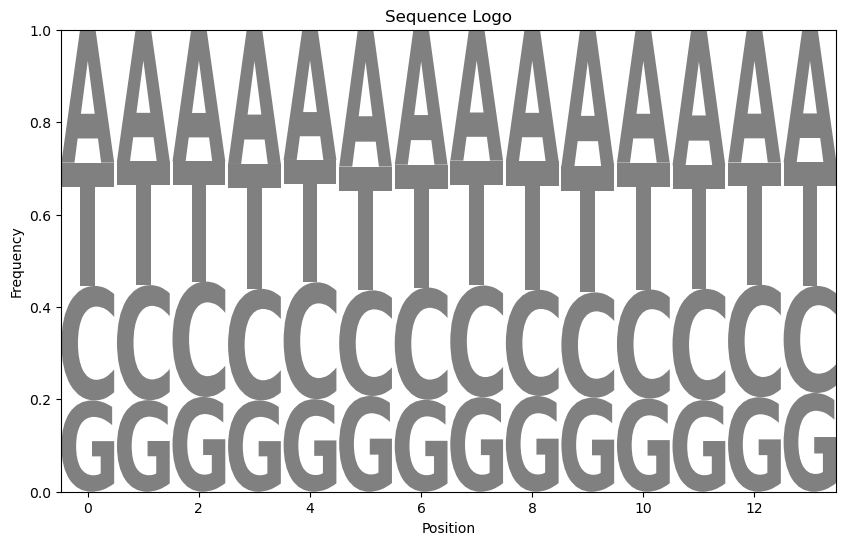

In [28]:
from collections import Counter
import logomaker
import matplotlib.pyplot as plt

# Extract sequences
sequences = A10map1_rptrbc['RPTR_BC'].values

# Initialize a list to hold counters for each position
counters = [Counter() for _ in range(14)]

# Count nucleotides at each position
for seq in sequences:
    for i, nucleotide in enumerate(seq):
        counters[i][nucleotide] += 1

# Convert counts to a DataFrame
count_data = {i: dict(counters[i]) for i in range(14)}
nucleotide_counts = pd.DataFrame.from_dict(count_data, orient='index').fillna(0)

# Normalize the counts to get frequencies
nucleotide_frequencies = nucleotide_counts.div(nucleotide_counts.sum(axis=1), axis=0)

# Create a DataFrame suitable for logomaker
logo_df = nucleotide_frequencies.reset_index(drop=True)
logo_df.columns.name = 'nucleotide'

# Create the sequence logo
fig, ax = plt.subplots(figsize=(10, 6))
logomaker.Logo(logo_df, ax=ax)
ax.set_xlabel('Position')
ax.set_ylabel('Frequency')
plt.title('Sequence Logo')
plt.show()


In [30]:
nucleotide_counts.head()

,C,A,G,T,N
0,20842572,24203576,16615313,22434112,204.0
1,20936986,23926356,16667863,22562775,175.0
2,21003873,23964502,17247713,21876686,192.0
3,20303758,24433836,16622454,22730333,318.0
4,21267778,23706785,16846869,22267301,178.0


In [21]:
# Sample data
data = {'sequence': [
    'AGCTTAGCTAACGT',
    'CGATCGATCGTACG',
    'TTAGCGTAGCTTAC',
    'GCTAGCTAGCTAGC',
    '00000000000000'  # Example of a row with all zeros
]}
df = pd.DataFrame(data)
df

,sequence
0,AGCTTAGCTAACGT
1,CGATCGATCGTACG
2,TTAGCGTAGCTTAC
3,GCTAGCTAGCTAGC
4,00000000000000


In [18]:
# Drop rows where the sequence is all zeros
df = df[df['sequence'] != '00000000000000']

# Split sequences into individual nucleotides
nucleotide_df = df['sequence'].apply(lambda x: pd.Series(list(x)))
print(nucleotide_df)
# Count the occurrences of each nucleotide at each position
nucleotide_counts = nucleotide_df.apply(lambda col: col.value_counts())
nucleotide_counts
# Fill NaN with 0 (in case some nucleotides do not appear in some positions)
nucleotide_counts = nucleotide_counts.fillna(0)

# Identify the most common nucleotide at each position
most_common_nucleotides = nucleotide_counts.idxmax()

# Print the result
print("Most common nucleotide at each position:")
print(most_common_nucleotides)


  0  1  2  3  4  5  6  7  8  9  10 11 12 13
0  A  G  C  T  T  A  G  C  T  A  A  C  G  T
1  C  G  A  T  C  G  A  T  C  G  T  A  C  G
2  T  T  A  G  C  G  T  A  G  C  T  T  A  C
3  G  C  T  A  G  C  T  A  G  C  T  A  G  C
Most common nucleotide at each position:
0     A
1     G
2     A
3     T
4     C
5     G
6     T
7     A
8     G
9     C
10    T
11    A
12    G
13    C
dtype: object


In [24]:
pip install logomaker


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 46.4 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


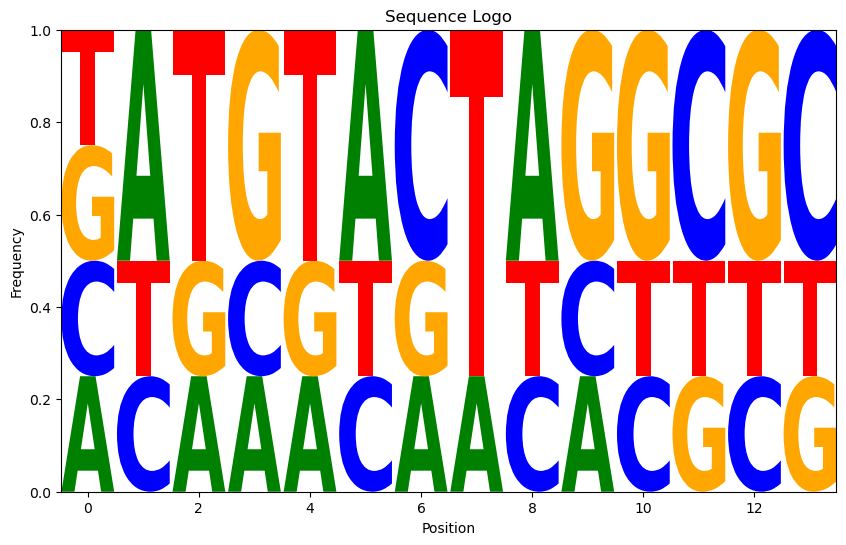

In [26]:
import pandas as pd
import numpy as np
from collections import Counter
import logomaker
import matplotlib.pyplot as plt

# Sample data
data = {'sequence': [
    'AGCTTAGCTAACGT',
    'CGATCGATCGTACG',
    'TTAGCGTAGCTTAC',
    'GCTAGCTAGCTAGC',
    '00000000000000'  # Example of a row with all zeros
]}
df = pd.DataFrame(data)

# Drop rows where the sequence is all zeros
df = df[df['sequence'] != '00000000000000']

# Extract sequences
sequences = df['sequence'].values

# Initialize a list to hold counters for each position
counters = [Counter() for _ in range(14)]

# Count nucleotides at each position
for seq in sequences:
    for i, nucleotide in enumerate(seq):
        counters[i][nucleotide] += 1

# Convert counts to a DataFrame
count_data = {i: dict(counters[i]) for i in range(14)}
nucleotide_counts = pd.DataFrame.from_dict(count_data, orient='index').fillna(0)

# Normalize the counts to get frequencies
nucleotide_frequencies = nucleotide_counts.div(nucleotide_counts.sum(axis=1), axis=0)

# Create a DataFrame suitable for logomaker
logo_df = nucleotide_frequencies.reset_index(drop=True)
logo_df.columns.name = 'nucleotide'

# Create the sequence logo
fig, ax = plt.subplots(figsize=(10, 6))
logomaker.Logo(logo_df, ax=ax)
ax.set_xlabel('Position')
ax.set_ylabel('Frequency')
plt.title('Sequence Logo')
plt.show()
